In [1]:
%matplotlib inline  

import imp
import matplotlib.pyplot as plot
import numpy as np
import os

import keras
import keras.backend
import keras.layers
import keras.models
import keras.utils

import innvestigate
import innvestigate.utils as iutils

Using TensorFlow backend.
C:\Users\minie\anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\minie\anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\minie\anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\minie\anaconda3\envs\gpu\lib\site-packages\t

In [5]:
import tarfile
import pandas as pd
import numpy as np
import re
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from keras.wrappers.scikit_learn import KerasClassifier

from keras.utils import to_categorical

from matplotlib import pyplot as plt

from Bio.Seq import Seq

### Read data

In [6]:
filename = "training_data.tar.gz"

data = tarfile.open(filename, "r:gz")
data.extractall()
data.close()

In [7]:
b = open('ghl_gold.fa','r')
bind = b.readlines()
b.close()

u = open('ghl_gold_random.fa','r')
unbind = u.readlines()
u.close()

### Data preprocessing

In [8]:
bind = [v for v in bind if '>' not in v]
bind = [s.replace('\n', '') for s in bind]
bind = [x.upper() for x in bind]

unbind = [v for v in unbind if '>' not in v]
unbind = [s.replace('\n', '') for s in unbind]
unbind = [x.upper() for x in unbind]

In [9]:
print(len(bind), len(unbind))

1400090 1400090


Reverse Complement

In [10]:
bind_rev = list(range(len(bind)))

for i in range(len(bind)):
  seq = Seq(bind[i])
  rev = seq.reverse_complement()
  bind_rev[i] = str(rev)

unbind_rev = list(range(len(unbind)))

for i in range(len(unbind)):
  seq = Seq(unbind[i])
  rev = seq.reverse_complement()
  unbind_rev[i] = str(rev)

In [11]:
bind_fb = bind + bind_rev
unbind_fb = unbind + unbind_rev

In [12]:
bind_label = [1 for i in range(len(bind_fb))]
unbind_label = [0 for i in range(len(unbind_fb))]

In [13]:
df = pd.DataFrame({"seq": bind_fb + unbind_fb, "label":bind_label + unbind_label})

##### split the dataset

In [14]:
from sklearn.utils import shuffle

new_df = shuffle(df)
new_df = new_df.reset_index()

In [15]:
x = new_df.seq
y = new_df.label

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=40)

One-Hot Encoding

In [17]:
LE = LabelEncoder()
LE.fit(['A', 'C', 'G', 'T', 'N'])

LabelEncoder()

In [18]:
start = datetime.now()

for index, row in x_train.items():
  x_train[index] = LE.transform(list(row))

for index, row in x_test.items():
  x_test[index] = LE.transform(list(row))

x_train = to_categorical(x_train.values.tolist())
x_t = to_categorical(x_test.values.tolist())

y_train = to_categorical(y_train.values.tolist())
y_t = to_categorical(y_test.values.tolist())

end = datetime.now()
print("encoding running time : "+str(end-start))

encoding running time : 0:05:19.471546


### RNN model

LSTM

In [19]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(20, 5), return_sequences=True))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(2, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 128)           68608     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 208,578
Trainable params: 208,578
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(x_train, y_train, epochs = 10, validation_split = 0.2)

Train on 3584230 samples, validate on 896058 samples
Epoch 1/10
  29152/3584230 [..............................] - ETA: 5:27:41 - loss: 0.5049 - acc: 0.7495

KeyboardInterrupt: 

### Visualization

In [22]:
# Creating an analyzer
gradient_analyzer = innvestigate.analyzer.Gradient(model)

# Applying the analyzer
analysis = gradient_analyzer.analyze(x_t)

# Displaying the gradient
plt.imshow(analysis.squeeze()[6], cmap='Greens', interpolation='nearest')
plt.show()

ResourceExhaustedError: OOM when allocating tensor with shape[1120072,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node lstm_1/Tile}} = Tile[T=DT_FLOAT, Tmultiples=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](lstm_1/ExpandDims, lstm_2/Tile/multiples)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node gradient_wrt_6/gradients/lstm_1/transpose_grad/transpose/_159}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2342_gradient_wrt_6/gradients/lstm_1/transpose_grad/transpose", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
seq_LE = np.argmax(x_t[6], axis=1)
seq = LE.inverse_transform(seq_LE)
print(seq)

['G' 'A' 'G' 'T' 'T' 'A' 'T' 'A' 'C' 'C' 'G' 'G' 'T' 'T' 'T' 'G' 'C' 'C'
 'C' 'A']


In [ ]:
seq_val = np.empty(20)
grad = analysis.squeeze()[6]

for i in range(20):
  nu = seq_LE[i]
  seq_val[i] = grad[i][nu]

In [ ]:
seq_val

array([-4.37065466e-07,  6.98022760e-08, -3.43956458e-07, -4.48813395e-08,
       -3.02401105e-07, -2.34457048e-07, -6.18931438e-07,  5.15979650e-07,
        1.79748145e-06, -8.63136584e-09,  1.25520467e-06,  1.60923761e-07,
       -2.91910737e-07, -1.23042309e-06, -1.20129175e-06,  2.12763183e-07,
       -1.96695893e-07,  4.13040979e-08, -5.97847645e-07, -3.78581433e-07])

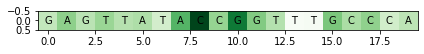

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(np.reshape(seq_val, (1,20)), cmap='Greens', interpolation='nearest')

for i in range(20):
        text = ax.text(i, 0, seq[i], ha="center", va="center", color="black")

fig.tight_layout()
plt.show()

BiLSTM

In [ ]:
bi_model = keras.layers.Sequential()
bi_model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True), input_shape=(20, 5)))
bi_model.add(keras.layers.Bidirectional(keras.layers.LSTM(64)))
bi_model.add(keras.layers.Dense(64, activation='relu'))
bi_model.add(keras.layers.Dropout(0.2))
bi_model.add(keras.layers.Dense(2, activation='sigmoid'))
bi_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
bi_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          335440    
_________________________________________________________________
bidirectional (Bidirectional (None, 20)                1680      
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 337,341
Trainable params: 337,341
Non-trainable params: 0
_________________________________________________________________


In [ ]:
bi_history = bi_model.fit(x_train, y_train, epochs = 10, validation_split = 0.2)

Epoch 1/10
112008/112008 [==============================] - 1016s 9ms/step - loss: 0.3593 - accuracy: 0.8423 - val_loss: 0.3233 - val_accuracy: 0.8588
Epoch 2/10
112008/112008 [==============================] - 978s 9ms/step - loss: 0.3220 - accuracy: 0.8615 - val_loss: 0.3176 - val_accuracy: 0.8613
Epoch 3/10
112008/112008 [==============================] - 967s 9ms/step - loss: 0.3147 - accuracy: 0.8650 - val_loss: 0.3173 - val_accuracy: 0.8613
Epoch 4/10
112008/112008 [==============================] - 956s 9ms/step - loss: 0.3122 - accuracy: 0.8666 - val_loss: 0.3174 - val_accuracy: 0.8614
Epoch 5/10
112008/112008 [==============================] - 957s 9ms/step - loss: 0.3094 - accuracy: 0.8678 - val_loss: 0.3180 - val_accuracy: 0.8611
Epoch 6/10
112008/112008 [==============================] - 957s 9ms/step - loss: 0.3081 - accuracy: 0.8687 - val_loss: 0.3195 - val_accuracy: 0.8614
Epoch 7/10
112008/112008 [==============================] - 970s 9ms/step - loss: 0.3069 - accuracy

Visualization

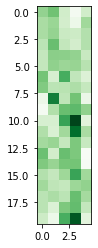

In [ ]:
# Creating an analyzer
bi_gradient_analyzer = innvestigate.analyzer.Gradient(bi_model)

# Applying the analyzer
bi_analysis = bi_gradient_analyzer.analyze(x_t)

# Displaying the gradient
plt.imshow(bi_analysis.squeeze()[6], cmap='Greens', interpolation='nearest')
plt.show()

In [ ]:
bi_seq_val = np.empty(20)
bi_grad = bi_analysis.squeeze()[6]

for i in range(20):
  nu = seq_LE[i]
  bi_seq_val[i] = bi_grad[i][nu]

In [ ]:
bi_seq_val

array([-4.37065466e-07,  6.98022760e-08, -3.43956458e-07, -4.48813395e-08,
       -3.02401105e-07, -2.34457048e-07, -6.18931438e-07,  5.15979650e-07,
        1.79748145e-06, -8.63136584e-09,  1.25520467e-06,  1.60923761e-07,
       -2.91910737e-07, -1.23042309e-06, -1.20129175e-06,  2.12763183e-07,
       -1.96695893e-07,  4.13040979e-08, -5.97847645e-07, -3.78581433e-07])

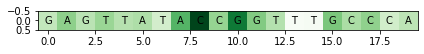

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(np.reshape(bi_seq_val, (1,20)), cmap='Greens', interpolation='nearest')

for i in range(20):
        text = ax.text(i, 0, seq[i], ha="center", va="center", color="black")

fig.tight_layout()
plt.show()

### Evaluation

Accuracy

In [ ]:
score = model.evaluate(x_t, y_t)
print("score = " + str(round(score[1],2)))

20000/20000 [==============================] - 9s 457us/step
score = 0.85


In [ ]:
bi_score = bi_model.evaluate(x_test, y_test)
print("score = " + str(round(bi_score[1],2)))

35003/35003 [==============================] - 96s 3ms/step - loss: 0.3200 - accuracy: 0.8608
score = 0.86


loss-epoch curve

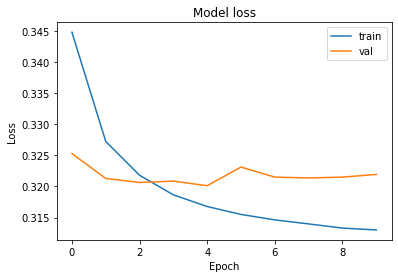

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

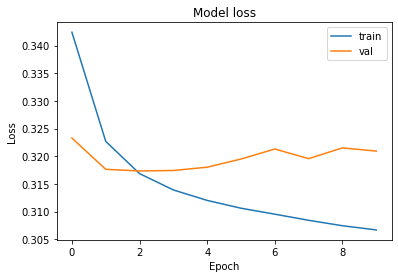

In [ ]:
plt.plot(bi_history.history['loss'])
plt.plot(bi_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

precision-recall curve

In [ ]:
probs = model.predict(x_t)[:,1]
bi_probs = bi_model.predict(x_t)[:,1]

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, probs)
bi_precision, bi_recall, bi_thresholds = precision_recall_curve(y_test, bi_probs)

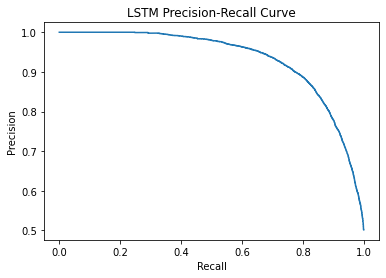

In [ ]:
plt.plot(recall, precision)

plt.title('LSTM Precision-Recall Curve')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.show()

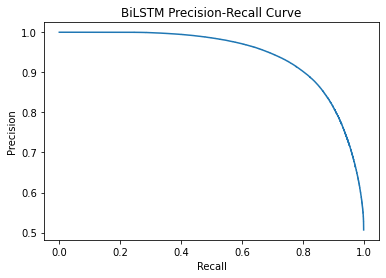

In [ ]:
plt.plot(bi_recall, bi_precision)

plt.title('BiLSTM Precision-Recall Curve')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.show()

ROC curve & AUC

In [ ]:
auc = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)

bi_auc = roc_auc_score(y_test, bi_probs)
bi_fpr, bi_tpr, bi_ = roc_curve(y_test, bi_probs)

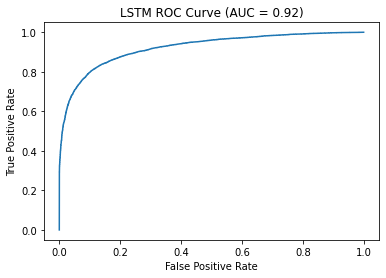

In [ ]:
plt.plot(fpr, tpr)
plt.title('LSTM ROC Curve (AUC = ' + str(round(auc,2)) + ')')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

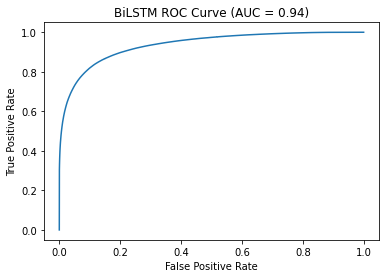

In [ ]:
plt.plot(bi_fpr, bi_tpr)
plt.title('BiLSTM ROC Curve (AUC = ' + str(round(bi_auc,2)) + ')')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

save the result

In [ ]:
result_dict = {'accuracy': score[1], 'loss': history.history['loss'], 'val_loss': history.history['val_loss'],
               'precision': precision, 'recall': recall, 'tpr': tpr, 'fpr': fpr, 'auc': auc}
result_df = pd.DataFrame({ key:pd.Series(value) for key, value in result_dict.items() })
result_df.head()

,accuracy,loss,val_loss,precision,recall,tpr,fpr,auc
0,0.859903,0.344799,0.325290,0.500224,1.000000,0.000000,0.0,0.934501
1,NaN,0.327238,0.321284,0.500224,0.999998,0.000054,0.0,NaN
2,NaN,0.321795,0.320636,0.500224,0.999998,0.000059,0.0,NaN
3,NaN,0.318644,0.320857,0.500226,0.999998,0.000889,0.0,NaN
4,NaN,0.316770,0.320116,0.500226,0.999998,0.003036,0.0,NaN


In [ ]:
result_df.to_csv ('LSTM_Emb_result.csv', index = False, header=True)

In [ ]:
bi_result_dict = {'accuracy': bi_score[1], 'loss': bi_history.history['loss'], 'val_loss': bi_history.history['val_loss'],
               'precision': bi_precision, 'recall': bi_recall, 'tpr': bi_tpr, 'fpr': bi_fpr, 'auc': bi_auc}
bi_result_df = pd.DataFrame({ key:pd.Series(value) for key, value in bi_result_dict.items() })
bi_result_df.head()

,accuracy,loss,val_loss,precision,recall,tpr,fpr,auc
0,0.860789,0.342405,0.323293,0.506835,1.000000,0.000000,0.0,0.935477
1,NaN,0.322696,0.317648,0.506835,0.999998,0.000705,0.0,NaN
2,NaN,0.316868,0.317347,0.506841,0.999998,0.007706,0.0,NaN
3,NaN,0.313920,0.317437,0.506841,0.999998,0.008645,0.0,NaN
4,NaN,0.312030,0.318029,0.506842,0.999998,0.010706,0.0,NaN


In [ ]:
bi_result_df.to_csv ('BiLSTM_Emb_result.csv', index = False, header=True)